In [1]:
# Covid19 Analysis

# Analysis using public hospital
# http://plataforma.saude.gov.br/coronavirus/dados-abertos/      

In [2]:
# libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
import pickle
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from xgboost import XGBClassifier
from datetime import datetime

/home/pedro/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# reading dataset

df = pd.read_csv('/home/pedro/Desktop/autoprognosis/code_v4/dataset/INFLUD-16-06-2020-Revisado.csv',sep=';',encoding = "ISO-8859-1")

# Inputing constraint in the dataset 

# Positive case:

df = df[df['PCR_SARS2']==1]
print(df.shape)


# Hospitalized people:

df = df[df['PCR_SARS2']==1][df['HOSPITAL']==1][df['NU_IDADE_N']<=110]
print(df.shape)

# Hospitalized people with age small than 110:

df = df[df['PCR_SARS2']==1][df['HOSPITAL']==1][df['NU_IDADE_N']<=110][df['EVOLUCAO'] != 9][df['EVOLUCAO'].notnull()]
print(df.shape)

# 

#print(df[df['PCR_SARS2']==1][df['HOSPITAL']==1][df['NU_IDADE_N']<=110][df['EVOLUCAO'] != 9][df['EVOLUCAO'].notnull()].value_counts())

/home/pedro/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,59,61,62,63,103,105,119,126,128,129,130,132) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(97924, 134)


/home/pedro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


(90132, 134)
(66929, 134)


/home/pedro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [4]:
# Municipalities number inicial

print(len(df['CO_MUN_NOT']))
print(len(df['CO_UNI_NOT']))

print(df['CO_MUN_NOT'].nunique())
print(df['CO_UNI_NOT'].nunique())

66929
66929
1085
2810


In [5]:
# IDHM

# Reading IBGE code for each municipalities and separating it for IDHM index

df_atlas = pd.read_excel (r'/home/pedro/Desktop/autoprognosis/code_v4/dataset/AtlasBrasil_Consulta.xlsx')


# removind last interger in 'code' variable

df_atlas['code'] = df_atlas['code'].astype(str).str[:-1].astype(np.int64)


# Divinding IDHM in bins

IDHM_veryhigh  =  set(df_atlas['code'][df_atlas['IDHM2010']>=0.800])
print(len(IDHM_veryhigh))


IDHM_high  =  set(df_atlas['code'][((df_atlas['IDHM2010']>=0.700)&(df_atlas['IDHM2010']<0.800))])
print(len(IDHM_high))


IDHM_medium  =  set(df_atlas['code'][((df_atlas['IDHM2010']>=0.600)&(df_atlas['IDHM2010']<0.700))])
print(len(IDHM_medium))


IDHM_low  =  set(df_atlas['code'][((df_atlas['IDHM2010']>=0.500)&(df_atlas['IDHM2010']<0.600))])
print(len(IDHM_low))


IDHM_verylow  =  set(df_atlas['code'][df_atlas['IDHM2010']<0.500])
print(len(IDHM_verylow))




df.loc[df['CO_MUN_NOT'].isin(IDHM_veryhigh) == True, 'IDHM'] = 5
df.loc[df['CO_MUN_NOT'].isin(IDHM_high) == True, 'IDHM'] = 4
df.loc[df['CO_MUN_NOT'].isin(IDHM_medium) == True, 'IDHM'] = 3
df.loc[df['CO_MUN_NOT'].isin(IDHM_low) == True, 'IDHM'] = 2
df.loc[df['CO_MUN_NOT'].isin(IDHM_verylow) == True, 'IDHM'] = 1


# Municipalities number analysed
#print(df['IDHM'].isnull().sum())


44
1890
2233
1367
32


In [6]:
# Private and public hospital separation

df_hospital = pd.read_csv('/home/pedro/Desktop/autoprognosis/code_v4/dataset/CNES_SUS.txt', sep='\t')


public   =  set(df_hospital.iloc[:,0][df_hospital.iloc[:,3]=='S'])
private  =  set(df_hospital.iloc[:,0][df_hospital.iloc[:,3]=='N'])


df.loc[df['CO_UNI_NOT'].isin(public) == True, 'HEALTH_SYSTEM'] = 1
df.loc[df['CO_UNI_NOT'].isin(private) == True, 'HEALTH_SYSTEM'] = 0


In [7]:
# Constraint on dataset: We only analyze people with  evolution, IDHM and Health system known

df = df[df['IDHM'].notnull()][(df['HEALTH_SYSTEM']==1)|(df['HEALTH_SYSTEM']==0)]
print(df.shape)


(63860, 136)


/home/pedro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
# Municipalities number

print(len(df['CO_MUN_NOT']))
print(len(df['CO_UNI_NOT']))

print(df['CO_MUN_NOT'].nunique())
print(df['CO_UNI_NOT'].nunique())



63860
63860
1072
2618


In [9]:
# To selecting features and target

df = df[['NU_IDADE_N','CS_SEXO','IDHM','CS_RACA','CS_ESCOL_N','SG_UF_NOT','CS_ZONA',\
'HEALTH_SYSTEM','CS_GESTANT','FEBRE','VOMITO','TOSSE','GARGANTA','DESC_RESP','DISPNEIA','DIARREIA',\
'SATURACAO','CARDIOPATI','HEPATICA','ASMA','PNEUMOPATI','RENAL','HEMATOLOGI','SIND_DOWN','DIABETES',\
'OBESIDADE','NEUROLOGIC','IMUNODEPRE','EVOLUCAO']]


In [10]:
# adding comorbidities

df['SUM_COMORBIDITIES'] = df.iloc[:,17:-1].replace([9,2], 0).fillna(0).sum(axis=1)


In [11]:
# Ordering features

df = df[['NU_IDADE_N','CS_SEXO','CS_RACA','IDHM','CS_ESCOL_N','SG_UF_NOT','SUM_COMORBIDITIES',\
'HEALTH_SYSTEM','CS_ZONA','CARDIOPATI','HEPATICA','ASMA','PNEUMOPATI','RENAL','HEMATOLOGI',\
'SIND_DOWN','DIABETES','OBESIDADE','NEUROLOGIC','IMUNODEPRE','EVOLUCAO']]



In [12]:
# Pre-Processing

df = df[df['EVOLUCAO'].notnull()][df['EVOLUCAO']!=9]#[df_BR['NU_IDADE_N'].notnull()]
df['CS_SEXO']=df['CS_SEXO'].replace({'M': 1, 'F':0, 'I':9, 'NaN':np.nan})


# replacing 2 by 0 (Death patients)
df.iloc[:,9:] = df.iloc[:,9:].replace(to_replace = 2.0, value =0) 


df['SG_UF_NOT'] = df['SG_UF_NOT'].map({'SP': 0, 'RJ':1, 'MG': 2 , 'ES':3, \
'RS':4, 'SC': 5, 'PR': 6, 'MT': 7, 'MS': 8, 'GO':9, 'DF':10, 'RO':11,'AC':12,'AM':13,\
'RR':14,'PA':15,'AP':16,'TO':17,'MA':18,'PI':19,'BA':20,'CE':21,'RN':22,'PB':23,'PE':24,'AL':25,'SE':26})

# For missing values in comorbidities and symptoms we filled by 0.
df.iloc[:,9:-1] = df.iloc[:,9:-1].fillna(0)



In [13]:
# Ordering features

df = df[['NU_IDADE_N','CS_SEXO','CS_RACA','IDHM','CS_ESCOL_N','SG_UF_NOT','SUM_COMORBIDITIES',\
'HEALTH_SYSTEM','CS_ZONA','CARDIOPATI','HEPATICA','ASMA','PNEUMOPATI','RENAL','HEMATOLOGI',\
'SIND_DOWN','DIABETES','OBESIDADE','NEUROLOGIC','IMUNODEPRE','EVOLUCAO']]


df = df.rename(columns={'NU_IDADE_N':'Age','CS_SEXO':'Sex','CS_RACA':'Race','IDHM':'IDHM',\
'CS_ESCOL_N':'Education','SG_UF_NOT':'State','SUM_COMORBIDITIES':'Sum Comorbidities',\
'HEALTH_SYSTEM':'Health System','CS_ZONA':'Urbanity','CARDIOPATI':'Cardiopathy','HEPATICA':'Liver',\
'ASMA':'Asthma','PNEUMOPATI':'Pneumopathy','RENAL':'Renal','HEMATOLOGI':'Hematological',\
'SIND_DOWN':'Down Syndrome','DIABETES':'Diabetes','OBESIDADE':'Obesity','NEUROLOGIC':'Neurological',\
'IMUNODEPRE':'Immunosuppression','EVOLUCAO':'EVOLUCAO'})




In [14]:
# feature
x = df.iloc[:,:-1]

# labels
y = df['EVOLUCAO']

In [15]:
# data separation
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.2, random_state=5)

In [16]:
print(y_train.shape)
print(y_test.shape)

(51088,)
(12772,)


In [16]:
#params = params = { 'booster ':['gbtree'],
#        'n_estimators': [100,150,200],          
#        'eta':[0.2],    
#        'max_depth':[4,5,7],
#        'gamma': [1],
#        'subsample': [0.3,0.5,0.9],
#        'colsample_bytree': [0.3,0.5,0.9],
#            }

# best
params = params = { 'booster ':['gbtree'],
        'n_estimators': [200],          
        'eta':[0.2],    
        'max_depth':[4],
        'gamma': [1],
        'subsample': [0.9],
        'colsample_bytree': [0.9],
            }


#{'booster ': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.2, 'gamma': 1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9}
                            
                            
xgb = XGBClassifier()
gs = GridSearchCV(estimator=xgb, param_grid=params, return_train_score=True, cv=10, scoring='roc_auc') 


gs = gs.fit(x_train, y_train)


print(gs.best_score_)
print(gs.best_params_)


print(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['std_test_score'])

print(gs.cv_results_['mean_train_score'])   
print(gs.cv_results_['std_train_score'])   


clf = gs.best_estimator_
clf.fit(x_train, y_train)


# save the model to disk
filename_nn = 'xgb_without_symptoms.sav'
pickle.dump(clf, open(filename_nn, 'wb')) 


[14:29:25] WARNING: /workspace/src/learner.cc:480: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:29:31] WARNING: /workspace/src/learner.cc:480: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:29:35] WARNING: /workspace/src/learner.cc:480: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above c

In [17]:
# load the model from disk
loaded_model_xgb = pickle.load(open('xgb_without_symptoms.sav', 'rb'))


In [18]:
# To predicting 
xgb_pred = loaded_model_xgb.predict_proba(x_test)

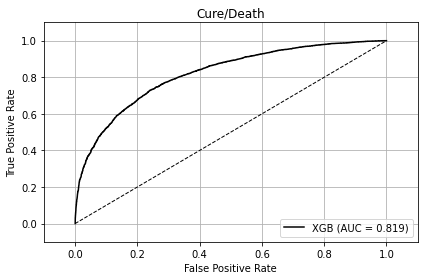

In [19]:
# Plot Roc Curve

colors = ['blue']
linestyles = ['--']
#plt.figure(figsize=(5,5))
fpr, tpr, thresholds = roc_curve(y_test, xgb_pred[:,1],pos_label=1)
roc_auc = auc(x=fpr, y=tpr)
plt.plot(fpr, tpr,
             color='k',
             linestyle='-',
             label='%s (AUC = %0.3f)' % ('XGB', roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='black',
         linewidth=1)

plt.title('')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.title('Cure/Death')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.tight_layout()
#plt.savefig('roc_xgb_private_without_symptoms.pdf')
plt.show()  

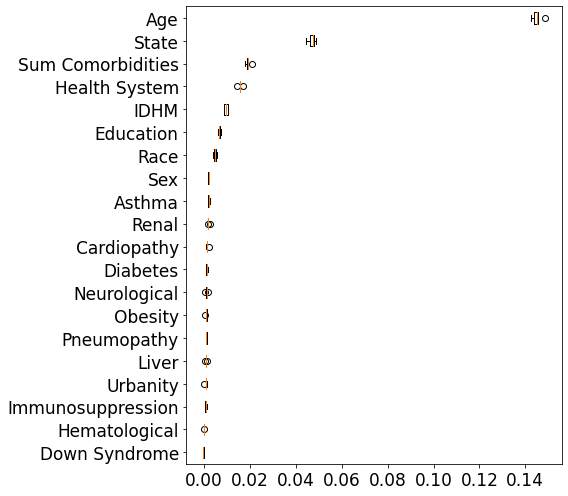

In [20]:
from sklearn.inspection import permutation_importance


result = permutation_importance(loaded_model_xgb, x_test, y_test, n_repeats=5,
                                random_state=42, n_jobs=2, scoring='average_precision')
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(8,7))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=x_test.columns[sorted_idx])
plt.yticks(fontsize=17) 
plt.xticks(fontsize=17) 

#ax.set_title("Permutation Importances (test set)")
#ax.set_xscale('log')
#plt.rcParams.update({'font.size': 22})
fig.tight_layout()
plt.savefig('importance_permutation_test.pdf')
plt.show() 
plt.close()

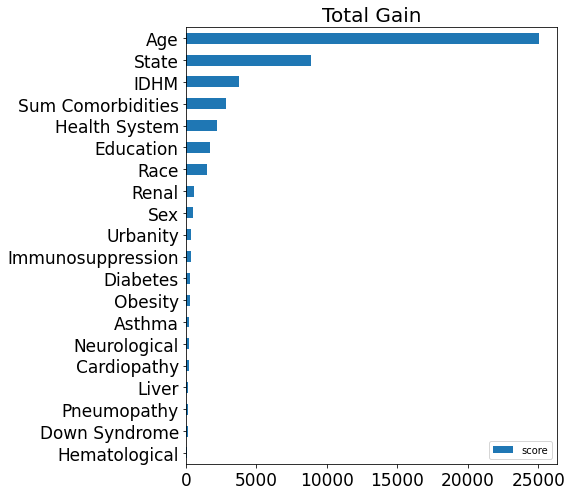

In [21]:
feature_important = loaded_model_xgb.get_booster().get_score(importance_type='total_gain')

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh',figsize=(8,7))
plt.title('Total Gain',fontsize=20)
plt.yticks(fontsize=17) 
plt.xticks(fontsize=17) 
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('total_gain.pdf')
plt.show()
plt.close()





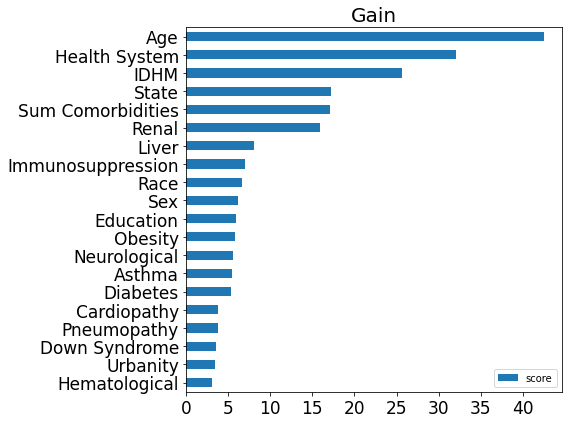

In [22]:
feature_important = loaded_model_xgb.get_booster().get_score(importance_type='gain')

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh',figsize=(8,6))
plt.title('Gain',fontsize=20)
plt.yticks(fontsize=17) 
plt.xticks(fontsize=17)
plt.tight_layout()
plt.savefig('gain.pdf')
plt.show()

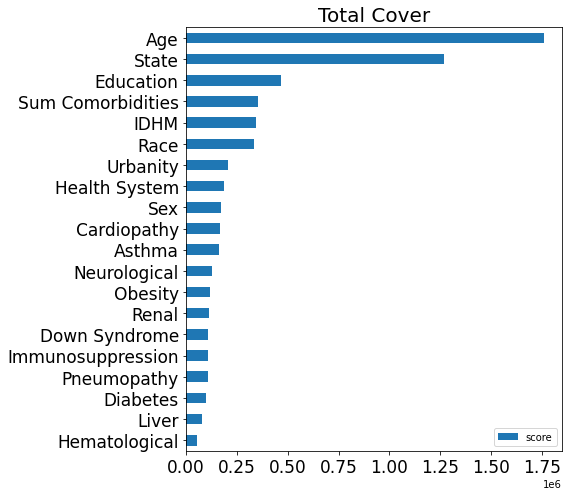

In [23]:
feature_important = loaded_model_xgb.get_booster().get_score(importance_type='total_cover')

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh',figsize=(8,7))
plt.title('Total Cover',fontsize=20)
plt.yticks(fontsize=17) 
plt.xticks(fontsize=17)
plt.tight_layout()
plt.savefig('total_cover.pdf')
plt.show()

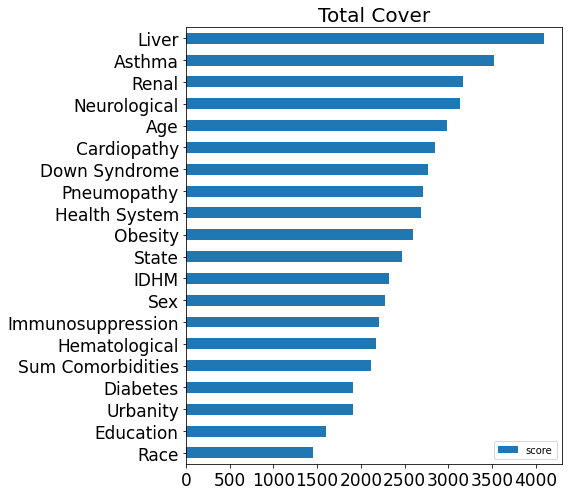

In [24]:
feature_important = loaded_model_xgb.get_booster().get_score(importance_type='cover')

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh',figsize=(8,7))
plt.title('Total Cover',fontsize=20)
plt.yticks(fontsize=17) 
plt.xticks(fontsize=17)
plt.tight_layout()
plt.savefig('total_cover.pdf')
plt.show()

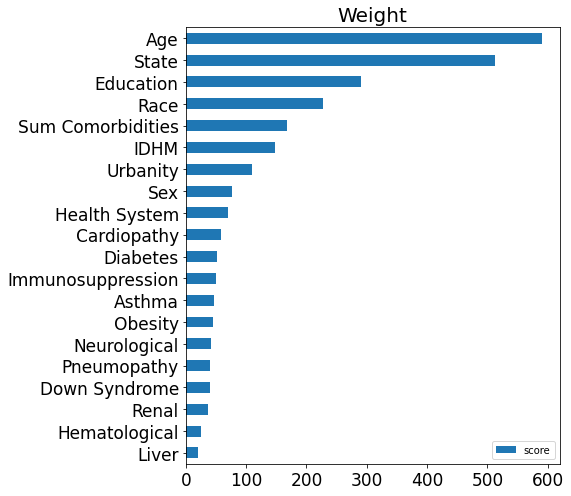

In [24]:
feature_important = loaded_model_xgb.get_booster().get_score(importance_type='weight')

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh',figsize=(8,7))
plt.title('Weight',fontsize=20)
plt.yticks(fontsize=17) 
plt.xticks(fontsize=17)
plt.tight_layout()
plt.savefig('weight.pdf')
plt.show()
plt.close()

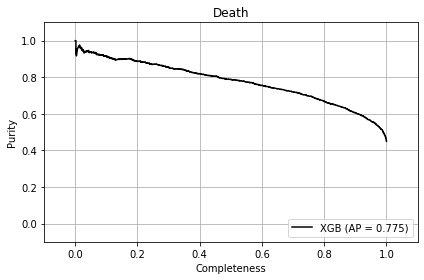

In [25]:
# Plot Purity x Completeness 


precision, recall, thresholds = precision_recall_curve(y_test, xgb_pred[:,0],pos_label=0)
average_precision = average_precision_score(1-y_test, xgb_pred[:,0])
plt.plot(recall, precision, color='k',linestyle='-',label='%s (AP = %0.3f)' % ('XGB', average_precision))

plt.legend(loc='lower right')


plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('Completeness')
plt.ylabel('Purity')
plt.title('Death')
plt.tight_layout()
plt.show()  

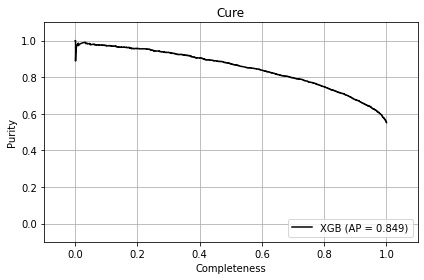

In [26]:
# Plot Purity x Completeness 


precision, recall, thresholds = precision_recall_curve(y_test, xgb_pred[:,1],pos_label=1)
average_precision = average_precision_score(y_test, xgb_pred[:,1])
plt.plot(recall, precision, color='k',linestyle='-',label='%s (AP = %0.3f)' % ('XGB', average_precision))

plt.legend(loc='lower right')


plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('Completeness')
plt.ylabel('Purity')
plt.title('Cure')
plt.tight_layout()
plt.show()  